# maybe the important thing here is to find things that are suboptimal, given some set of options?


In [12]:
from ipypb import track as tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numba
import random
import diffplan
import astar
import envs
import prior_envs
%load_ext autoreload
%autoreload 2
%matplotlib inline

eps = torch.finfo().eps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
env = diffplan.Grid('''
x   x   xx
x       xx
x   x   xx
x xxxxx xx
x   x   xx
x   x   xx
xSxxxGxxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x     xxxx
''')

heuristic_cost_estimate = astar.compute_manhattan_heuristic(env)
D, a_cost = astar.compute_astar_matrix(env, heuristic_cost_estimate, tqdm=tqdm, samples=20)
xx_cost = D + a_cost

def find_suboptimal(env, xx_cost, D):
    for s in env.states:
        for g in env.states:
            c = xx_cost[s, :] + xx_cost[:, g]
            opts = np.where(c==c.min())[0]
            # For all good options, is there any where the cost is not the optimal?
            for o in opts:
                if D[s, o] + D[o, g] > D[s, g]:
                    print(D[s, o] + D[o, g], D[s, g], env.states_features[s], env.states_features[o], env.states_features[g])

find_suboptimal(env, xx_cost, D)

 [████████████████████████████████████████████████████████████] 54/54 [00:12<00:00, 0.22s/it]

tensor(20.) tensor(18.) (6, 1) (13, 5) (6, 5)
tensor(20.) tensor(18.) (6, 1) (14, 2) (6, 5)
tensor(20.) tensor(18.) (6, 1) (14, 3) (6, 5)
tensor(20.) tensor(18.) (6, 1) (14, 4) (6, 5)
tensor(20.) tensor(18.) (6, 1) (14, 5) (6, 5)
tensor(20.) tensor(18.) (7, 1) (13, 5) (5, 5)
tensor(20.) tensor(18.) (7, 1) (14, 2) (5, 5)
tensor(20.) tensor(18.) (7, 1) (14, 3) (5, 5)
tensor(20.) tensor(18.) (7, 1) (14, 4) (5, 5)
tensor(20.) tensor(18.) (7, 1) (14, 5) (5, 5)
tensor(21.) tensor(19.) (7, 5) (13, 1) (5, 2)
tensor(21.) tensor(19.) (7, 5) (14, 3) (5, 2)
tensor(21.) tensor(19.) (7, 5) (14, 4) (5, 2)
tensor(22.) tensor(20.) (7, 5) (13, 1) (5, 3)
tensor(20.) tensor(18.) (8, 1) (13, 5) (4, 5)
tensor(20.) tensor(18.) (8, 1) (14, 2) (4, 5)
tensor(20.) tensor(18.) (8, 1) (14, 3) (4, 5)
tensor(20.) tensor(18.) (8, 1) (14, 4) (4, 5)
tensor(20.) tensor(18.) (8, 1) (14, 5) (4, 5)
tensor(21.) tensor(19.) (8, 5) (13, 1) (4, 2)
tensor(21.) tensor(19.) (8, 5) (14, 3) (4, 2)
tensor(21.) tensor(19.) (8, 5) (14

In [16]:
env = envs.Blocks(3, hanoi=True, canonicalize=False, height_limits=(3,3,3)) # 80s for 5, canonicalize=True
print(len(env.states))

%time D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)
xx_cost = (D + BFS)

#heuristic_cost_estimate = envs.compute_blocks_distance_heuristic(env)
#D, a_cost = astar.compute_astar_matrix(env, heuristic_cost_estimate, tqdm=tqdm, samples=20)
#xx_cost = D + a_cost

find_suboptimal(env, xx_cost, D)


27


 [████████████████████████████████████████████████████████████] 27/27 [00:17<00:01, 0.62s/it]

# understanding xxx

In [702]:
def op(
    # should truly be a cost that we intend to minimize, as it is negated below.
    env, terminations, search_cost, *,
    # standard VI arguments
    vi_eps=1e-5,
    meta_beta=1.,
    coef_entropy=0,
):
    #assert False
    max_iter = len(env.states) * 5
    num_options = terminations.shape[0]

    goal_set = {env.states_to_idx[g] for g in env.goal_set}
    eta = terminations.softmax(dim=1) # (options, states)

    # Get meta-policy
    V = torch.zeros(len(env.states))
    for idx in range(max_iter):
        prev = V
        Q = torch.zeros((len(env.states), num_options))
        for s in env.states:
            if s in goal_set:
                continue
            Q[s] = eta@(V - search_cost[s])
        #V = (meta_beta*Q).logsumexp(axis=1)/meta_beta
        policy = (meta_beta*Q).softmax(dim=1)
        entropy = 0
        if coef_entropy != 0:
            entropy = -(policy*(eps+policy).log()).sum(1)
        V = (policy*Q).sum(1) + coef_entropy*entropy / meta_beta
        if torch.norm(V-prev) < vi_eps:
            break
    J = -torch.mean(V[torch.tensor(env.start_states)])
    #policy = (meta_beta*Q).softmax(dim=1)
    return J, V, Q, policy, eta

In [ ]:
env = envs.Blocks(3, hanoi=True, canonicalize=False)
#%time D = diffplan.compute_distance_matrix(env)
#BFS = diffplan.compute_bfs_matrix(env, D)
h = envs.compute_blocks_distance_heuristic(env)
a_star_distance, a_star_cost = astar.compute_astar_matrix(env, h, samples=100, tqdm=tqdm)

In [847]:
search_cost = (a_star_distance + a_star_cost).float()
#search_cost = (D + .5*BFS) + 1 # 23 -> 3 -> goal
#search_cost = (D + .9*BFS) + 2 # 4 -> goal
#search_cost = (D + BFS)

#os = option_set = [3, 4, 10, 19, 20, 23]
#os = option_set = [20, 4, 23, 3, 10, 19]
os = option_set = [23, 3, 20, 4, 10, 19]
#os = option_set = [3, 4, 20]

s = env.states_to_idx[(('B', 'A'),(),('C',))]
g = env.states_to_idx[(('C', 'A'),(),('B',))] # from the paper!

env.goal_set = {env.states_features[g]}
env.start_states = env.states

'''
terms = torch.zeros((1+len(os), len(env.states)))
for o, oval in enumerate(os):
    terms[o, oval] = 100.
terms[len(os), g] = 100.
'''
terms = torch.zeros((1+len(os), len(env.states)))
terms[0, g] = 100.
for o, oval in enumerate(os):
    terms[o+1, oval] = 100.

r = diffplan.option_planner_bfs_vec(env, terms, search_cost)
#r = op(env, terms, search_cost)
#r = op(env, terms, search_cost)

#J, V, Q, policy, eta
policy = r[3]


# now seeing what's in the policy...
print(s, g)
def t(s):
    aidx = np.argmax(policy[s]) - 1
    if aidx == -1: return g
    print(option_set[aidx], policy[s, aidx], sorted([(round(p, 2), o) for o, p in zip(option_set, policy[s].numpy()) if p > 1e-3])[::-1])
    assert option_set[aidx] != s
    return option_set[aidx]

x = s
ct = 0
while x != g:
    x = t(x)
    ct += 1
    if ct > 10:
        break

20 21
20 tensor(0.2031) [(0.37, 4), (0.2, 20), (0.18, 10), (0.17, 3), (0.01, 19)]


AssertionError: 

20
20
20


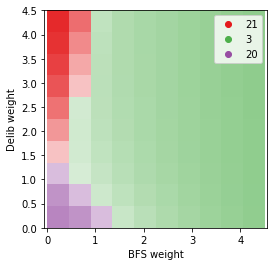

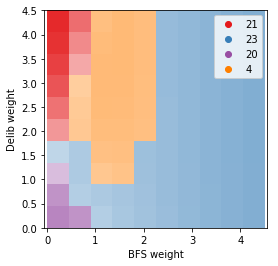

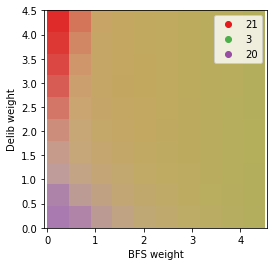

In [849]:
def do_grouping(gridp_full):
    i = {n: idx+1 for idx, n in enumerate(option_set)}
    newthing = np.zeros((gridp_full.shape[0], gridp_full.shape[1], gridp_full.shape[2]-2))

    assert set(option_set[:4]) == {3,4,20,23}, 'hack hack hack'
    newthing[:, :, 0] = gridp_full[:, :, 0]
    newthing[:, :, i[20]] = gridp_full[:, :, i[20]]
    newthing[:, :, i[4]] = gridp_full[:, :, i[4]] + gridp_full[:, :, i[19]]
    newthing[:, :, i[23]] = gridp_full[:, :, i[23]] + gridp_full[:, :, i[3]] + gridp_full[:, :, i[10]]

    return newthing

def render_grid(wBFSs, wdelibs, *, cost_scaling=1., beta=1., coef_entropy=0., vec=True, ax=None, group=False, showmax=True):
    results = {}
    #grid = np.zeros((len(wBFSs), len(wdelibs)))
    #gridp = np.full((len(wBFSs), len(wdelibs), len(option_set)+1), np.nan)
    gridp_full = np.full((len(wBFSs), len(wdelibs), len(option_set)+1), np.nan)
    Qs = np.full((len(wBFSs), len(wdelibs), len(option_set)+1), np.nan)
    for wBFSidx, wBFS in enumerate(wBFSs):
        for wdelibidx, wdelib in enumerate(wdelibs):
            dist = D
            plancost = BFS
            dist = a_star_distance
            plancost = a_star_cost
            search_cost = ((dist + wBFS*plancost) + wdelib)*cost_scaling
            if vec:
                r = diffplan.option_planner_bfs_vec(env, terms, search_cost, meta_beta=beta)
            else:
                r = op(env, terms, search_cost, meta_beta=beta, coef_entropy=coef_entropy)
            policy = r[3]
            results[(wBFS, wdelib)] = policy[s]
            best = np.argmax(policy[s])
            #grid[wBFSidx, wdelibidx] = best
            gridp_full[wBFSidx, wdelibidx] = policy[s]

            Q = r[2]
            Qs[wBFSidx, wdelibidx] = Q[s]
    if group:
        gridp_full = do_grouping(gridp_full)
    plot_grid(wBFSs, wdelibs, gridp_full, ax=ax, showmax=showmax)
    return gridp, gridp_full, Qs, wBFSs, wdelibs

def plot_grid(wBFSs, wdelibs, gridp_full, cmap='Set1', ax=None, showmax=True):
    n_opts = gridp_full.shape[-1]
    gridp = np.full((len(wBFSs), len(wdelibs), n_opts), np.nan)
    for wBFSidx, wBFS in enumerate(wBFSs):
        for wdelibidx, wdelib in enumerate(wdelibs):
            policy = gridp_full[wBFSidx, wdelibidx]
            best = np.argmax(policy)
            gridp[wBFSidx, wdelibidx, best] = policy[best]

    im = gridp if showmax else gridp_full

    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))
    plt.sca(ax)
    cm = plt.get_cmap(cmap)
    #plt.imshow(grid.T, extent=[wBFSs.min(), wBFSs.max(), wdelibs.min(), wdelibs.max()])
    for idx in range(n_opts):
        plt.imshow(
            im[:, ::-1, idx].T,
            cmap=diffplan.new_opacity_cmap(cm(idx)),
            extent=[wBFSs.min(), wBFSs.max(), wdelibs.min(), wdelibs.max()],
            vmin=0, vmax=1)
    plt.xlabel('BFS weight')
    plt.ylabel('Delib weight')
    plt.axis('equal')

    print(s)
    osxx = [g]+option_set
    nan_opt = np.all(np.isnan(gridp), axis=(0, 1))
    assert nan_opt.shape == (n_opts,)
    legend_elements = [
        plt.Line2D([0], [0], marker='o',
                   markeredgecolor=cm(idx),
                   markerfacecolor=cm(idx),
                   c=(0, 0, 0, 0),
                   label=str(osxx[idx]))
        for idx in range(n_opts)
        if not nan_opt[idx]
    ]
    plt.legend(handles=legend_elements)

#wBFSs = np.arange(0, 2., 0.2)
#wdelibs = np.arange(0, 4, 0.2)
wBFSs = np.arange(0, 8., 0.5)
wdelibs = np.arange(0, 8, 0.5)
#wBFSs = np.arange(0, 5., 0.3)
#wdelibs = np.arange(0, 5., 0.3)

d=render_grid(np.arange(0, 5., 0.5), np.arange(0, 5, 0.5), vec=True)
d=render_grid(np.arange(0, 5., 0.5), np.arange(0, 5, 0.5), vec=True, group=True)
d=render_grid(np.arange(0, 5., 0.5), np.arange(0, 5, 0.5), vec=True, showmax=False)

20


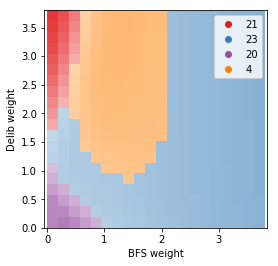

In [850]:
d=render_grid(np.arange(0, 4., 0.2), np.arange(0, 4, 0.2), vec=True, group=True)

20
20
20


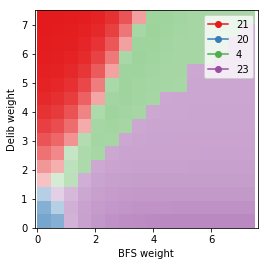

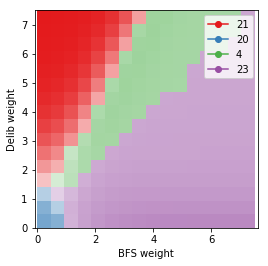

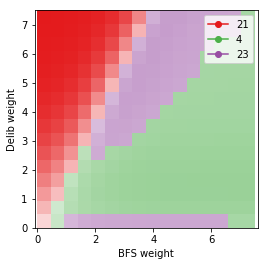

In [818]:
d=render_grid(wBFSs, wdelibs, vec=True)
d=render_grid(wBFSs, wdelibs, vec=False, coef_entropy=1.)
d=render_grid(wBFSs, wdelibs, vec=False)

20
20


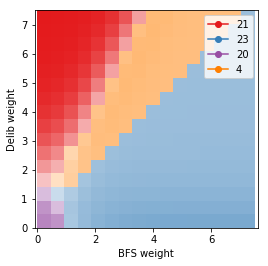

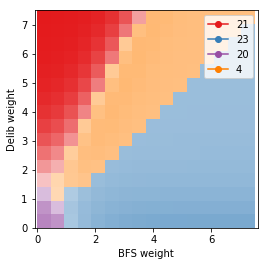

In [812]:
d=render_grid(wBFSs, wdelibs, vec=True)
d=render_grid(wBFSs, wdelibs, vec=True, group=True)

20


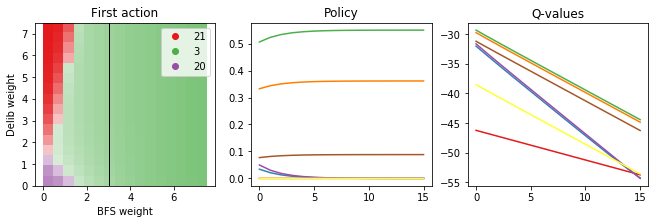

In [835]:
# Trying to see how beta changes this & differs for different ones...

def _show(axs, d):
    _, gridp_full, Qs, _, _ = d
    idx = 6
    axs[0].axvline(wBFSs[idx], lw=1, c='k')
    cm = plt.get_cmap('Set1')
    for i in range(gridp_full.shape[-1]):
        axs[1].plot(gridp_full[idx][:, i], c=cm(i))
        axs[2].plot(Qs[idx][:, i], c=cm(i))
    axs[0].set(title='First action')
    axs[1].set(title='Policy')
    axs[2].set(title='Q-values')

for vec in [True]:#[True, False]:
    for beta in [1]:#[0.5, 1, 5]:
        f, axs = plt.subplots(1, 3, figsize=(11, 3))
        d=render_grid(wBFSs, wdelibs, ax=axs[0], vec=vec, beta=beta, group=group)
        _show(axs, d)


20
20
20


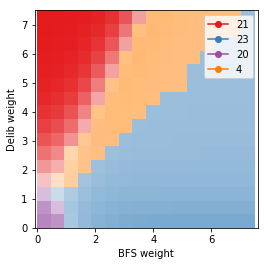

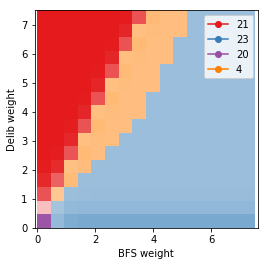

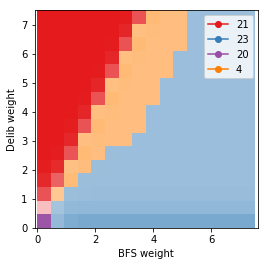

In [815]:
n = 3
d=render_grid(wBFSs, wdelibs, vec=True, cost_scaling=1/n, beta=n)
d=render_grid(wBFSs, wdelibs, vec=True, cost_scaling=n)
d=render_grid(wBFSs, wdelibs, vec=True, beta=n)

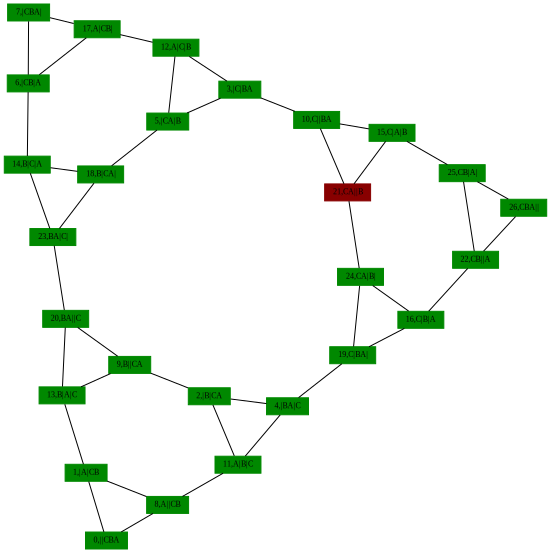

In [412]:
diffplan.plot_graph(
    env,
    labels=[str(idx)+','+'|'.join(''.join(c) for c in s) for idx, s in enumerate(env.states_features)],
)

In [318]:
def distance_under_policy(env, policy, D, g, s, path=False):
    #print(s, g)
    path = path or [s]
    aidx = np.argmax(policy[s])
    if aidx == len(option_set) or option_set[aidx] == g or s == g:
        path.append(g)
        return path, D[s,g]
    #print(option_set[aidx], policy[s, aidx], sorted([(round(p, 2), o) for o, p in zip(option_set, policy[s].numpy()) if p > 1e-3])[::-1])
    ns = option_set[aidx]
    path.append(ns)
    if ns in path or ns == s:
        pnew = torch.tensor(policy)
        pnew[s, aidx] = 0
        return distance_under_policy(env, pnew, D, g, s, path=path)
    #assert ns != s, (s, g)
    npath, nd = distance_under_policy(env, policy, D, g, ns, path=path)
    return npath, D[s, ns] + nd
distance_under_policy(env, policy, D, g, s), distance_under_policy(env, policy, D, g, s), D[s,g]

(([26, 26], tensor(0.)), ([26, 26], tensor(0.)), tensor(0.))

In [320]:
'''
%time D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)
search_cost = (D + BFS) + 4
'''

os = option_set = [3, 4, 10, 19, 20, 23]
terms = torch.zeros((1+len(os), len(env.states)))
for o, oval in enumerate(os):
    terms[o, oval] = 100.
terms[len(os), g] = 100.
env.start_states = env.states

for g in tqdm(env.states):
    env.goal_set = {env.states_features[g]}
    r = diffplan.option_planner_bfs_vec(env, terms, search_cost)
    policy = r[3]

    for s in env.states:
        path, r_dist = distance_under_policy(env, policy, D, g, s)
        if r_dist > D[s,g]:
            print('over xxx', s,g, '..', r_dist, D[s,g])

'''
# now seeing what's in the policy...
print(s, g)
def t(s):
    aidx = np.argmax(policy[s])
    if aidx == len(option_set): return g
    print(option_set[aidx], policy[s, aidx], sorted([(round(p, 2), o) for o, p in zip(option_set, policy[s].numpy()) if p > 1e-3])[::-1])
    assert option_set[aidx] != s
    return option_set[aidx]

x = s
while x != g:
    x = t(x)
'''

 [████████████████████████████████████████████████████████████] 27/27 [00:01<00:00, 0.04s/it]

/Users/carlos/pu/neu502b/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


"\n# now seeing what's in the policy...\nprint(s, g)\ndef t(s):\n    aidx = np.argmax(policy[s])\n    if aidx == len(option_set): return g\n    print(option_set[aidx], policy[s, aidx], sorted([(round(p, 2), o) for o, p in zip(option_set, policy[s].numpy()) if p > 1e-3])[::-1])\n    assert option_set[aidx] != s\n    return option_set[aidx]\n\nx = s\nwhile x != g:\n    x = t(x)\n"

In [ ]:
def find_suboptimal(env, xx_cost, D):
    for s in env.states:
        for g in env.states:
            c = xx_cost[s, :] + xx_cost[:, g]
            opts = np.where(c==c.min())[0]
            # For all good options, is there any where the cost is not the optimal?
            for o in opts:
                if D[s, o] + D[o, g] > D[s, g]:
                    print(D[s, o] + D[o, g], D[s, g], env.states_features[s], env.states_features[o], env.states_features[g])

find_suboptimal(env, xx_cost, D)